In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from ADDA.data import augmentations
import ADDA
import torch
import matplotlib.pyplot as plt
# PyTorch TensorBoard support
#from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

train_transform, test_transform = augmentations.supervised_augmentations()

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision
import json
import matplotlib.pyplot as plt
import os
import torch.optim as optim
from model import GoogLeNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model_f_train_data_path = "I_train.npy"
model_f_train_labels_path = "I_train_label.npy"

model_f_test_data_path = "I_test.npy"#val
model_f_test_labels_path =  "I_test_label.npy"

model_f_test2_data_path = "I_test2.npy"#test
model_f_test2_labels_path =  "I_test2_label.npy"
# target domain: model_j
model_j_train_data_path = "II_train.npy"
model_j_train_labels_path ="II_train_label.npy"

model_j_test_data_path = "II_test.npy"
model_j_test_labels_path = "II_test_label.npy"

model_j_test2_data_path = "III_test2.npy"
model_j_test2_labels_path =  "II_test2_label.npy"
# test domain: model_k
model_k_train_data_path = "III_train.npy"
model_k_train_labels_path ="II_train_label.npy"

model_k_test_data_path = "III_test.npy"
model_k_test_labels_path = "III_test_label.npy"

model_k_test2_data_path = "III_test2.npy"
model_k_test2_labels_path =  "III_test2_label.npy"
from ADDA.data.dataset import get_dataloader

bs =100

train_loader = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform, bs)
validate_loader = get_dataloader(model_f_test_data_path, model_f_test_labels_path, test_transform, bs)

source_dataloader_test2 = get_dataloader(model_f_test2_data_path, model_f_test2_labels_path, test_transform, bs)
target_dataloader_test2 = get_dataloader(model_j_test2_data_path, model_j_test2_labels_path, test_transform, bs)
test_dataloader_test2 = get_dataloader(model_k_test2_data_path, model_k_test2_labels_path, test_transform, bs)

cuda:0


In [4]:
net = GoogLeNet(num_classes=3, aux_logits=True, init_weights=True)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
val_num = 1800
best_acc = 0.0
save_path = './googleNet.pth'
for epoch in range(50):
    # train
    net.train()
    running_loss = 0.0
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        optimizer.zero_grad()
        logits, aux_logits2, aux_logits1 = net(images.to(device))
        loss0 = loss_function(logits, labels.squeeze(1).to(device))
        loss1 = loss_function(aux_logits1,labels.squeeze(1).to(device))
        loss2 = loss_function(aux_logits2, labels.squeeze(1).to(device))
        loss = loss0 + loss1 * 0.3 + loss2 * 0.3
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            val_labels = val_labels .reshape(-1).to(device)
            outputs = net(val_images.to(device))  # eval model only have last output layer
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
              (epoch + 1, running_loss / step, val_accurate))

print('Finished Training')


train loss: 100%[**************************************************->]1.828282[epoch 1] train_loss: 244.847  test_accuracy: 0.342
train loss: 100%[**************************************************->]1.765[epoch 2] train_loss: 1.825  test_accuracy: 0.349
train loss: 100%[**************************************************->]1.746[epoch 3] train_loss: 1.805  test_accuracy: 0.347
train loss: 100%[**************************************************->]1.766[epoch 4] train_loss: 1.788  test_accuracy: 0.333
train loss: 100%[**************************************************->]1.750[epoch 5] train_loss: 1.782  test_accuracy: 0.378
train loss: 100%[**************************************************->]1.756[epoch 6] train_loss: 1.775  test_accuracy: 0.398
train loss: 100%[**************************************************->]1.776[epoch 7] train_loss: 1.771  test_accuracy: 0.372
train loss: 100%[**************************************************->]1.692[epoch 8] train_loss: 1.756  test_accuracy: 0

In [5]:
torch.save(net.state_dict(), "GoogleNet.pt")

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
def test(model,dataloader, return_lists_roc=False):
    labels_list = np.array([])
    outputs_list = np.array([])
    preds_list = np.array([])
    with torch.no_grad():
        correct = 0
        total = 0
    i=0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.reshape(-1).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i==0:
            labels_list=labels.detach().cpu().numpy()
            outputs_list=outputs.data.detach().cpu().numpy()
            preds_list=predicted.detach().cpu().numpy()
            i=1
        else:
            labels_list=np.append(labels_list,labels.detach().cpu().numpy())
            outputs_list=np.append(outputs_list,outputs.data.detach().cpu().numpy(),axis=0)
            preds_list=np.append(preds_list,predicted.detach().cpu().numpy())
    if return_lists_roc:
        return 100 * correct / total, np.array(labels_list), np.array(outputs_list),np.array(preds_list)
    else:
        return 100 * correct / total
def plot_cm_roc(self, dataloader, output_path=None, n_classes=3):
    """
    Plots the confusion matrix and ROC curves of the model on `dataloader`.

    Arguments:
    ----------
    dataloader: PyTorch DataLoader
        DataLoader with test data.

    n_classes: int
        Number of classes.

    output_path: str
        Output path to .npz (NumPy) file containing the true positive rate, false positive rate
        and AUROC.
        To obtain the information, load the .npz file with `allow_picle=True` and select the data
        of interest with `array['tpr'].item()`, `array['fpr'].item()` or `array['roc_auc'].item()`.
    """

    cmap = sns.diverging_palette(0, 255, sep=1, n=256, as_cmap=True)

    accuracy, labels_list, outputs_list, preds_list =test(self,dataloader, return_lists_roc=True)
    #labellist: true labels
    #outputs_list: predicted labels
    # plot confusion matrix
    cm = sklearn.metrics.confusion_matrix(labels_list, preds_list)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['({0:.2%})'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(n_classes,n_classes)
    #tn, fp, fn, tp = cm.ravel()

    plt.figure(figsize=(4,4), dpi=200)
    categories = ['axion', 'cdm', 'no'] #  0:axion 1:cdm 2:no 
    sns.heatmap(cm, annot=labels, cmap=cmap, fmt="", xticklabels=categories, yticklabels=categories)
    plt.title("Confusion matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()
    color=['darkorange','darkblue','darkgreen']
    # plot roc
    ## one hot encode data
    label_binarizer = LabelBinarizer().fit( labels_list)
    onehot = label_binarizer.transform(labels_list)
    print(onehot.shape)
    fig, ax = plt.subplots()
    ax.set_title("One vs rest ROC curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    for class_of_interest in range(n_classes):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        plot_chance_level =False
        ## get roc curve and auroc for each class
        if class_of_interest == n_classes-1:
            plot_chance_level=True
        display = RocCurveDisplay.from_predictions(
            onehot[:, class_id],
            outputs_list[:, class_id],
            name=f"{categories[class_of_interest]} vs the rest",
            color=color[class_of_interest],
            plot_chance_level=plot_chance_level ,
            ax=ax, 
        )
   

accuracy on test set = 85.61111111111111


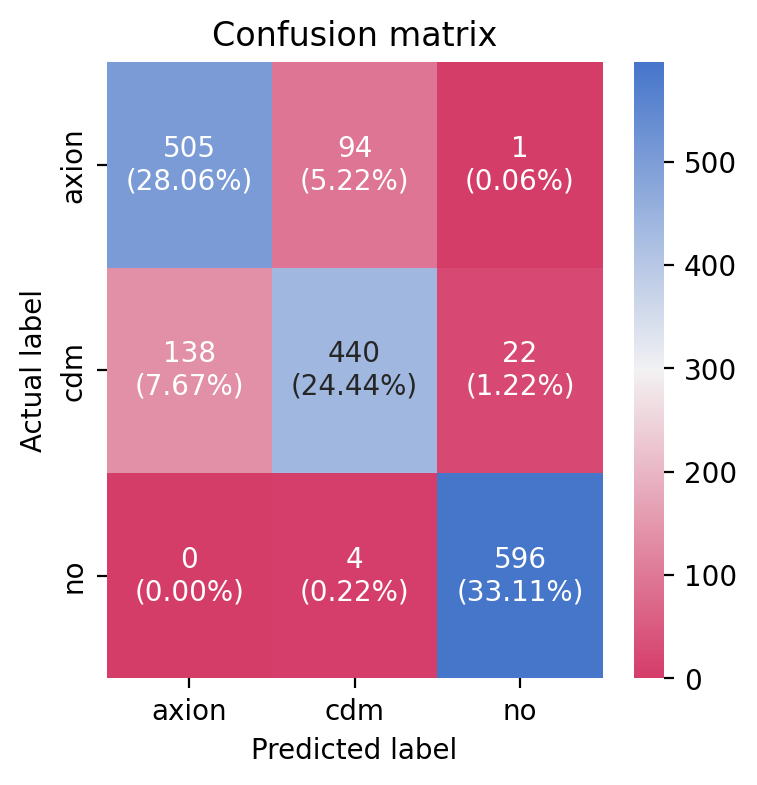

(1800, 3)


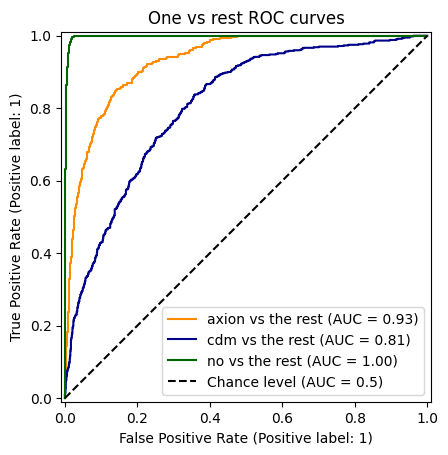

In [10]:
print(f"accuracy on test set = {test(net,source_dataloader_test2)}")
plot_cm_roc(net,source_dataloader_test2, output_path=None, n_classes=3)

accuracy on test set = 32.72222222222222


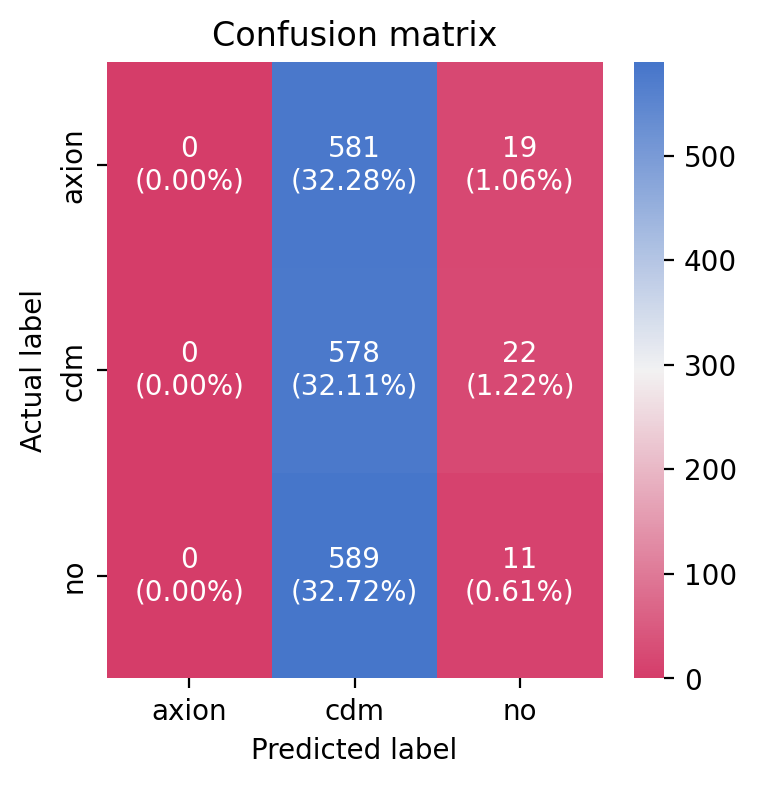

(1800, 3)


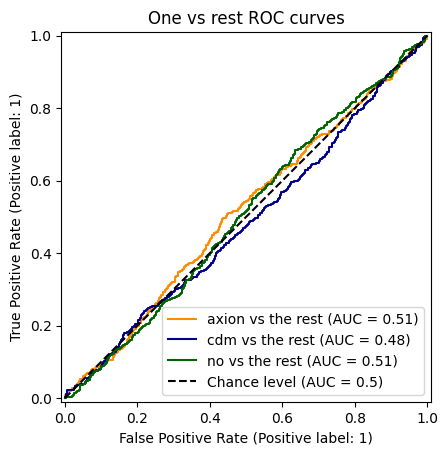

In [12]:
print(f"accuracy on test set = {test(net,target_dataloader_test2)}")
plot_cm_roc(net,target_dataloader_test2, output_path=None, n_classes=3)

accuracy on test set = 32.72222222222222


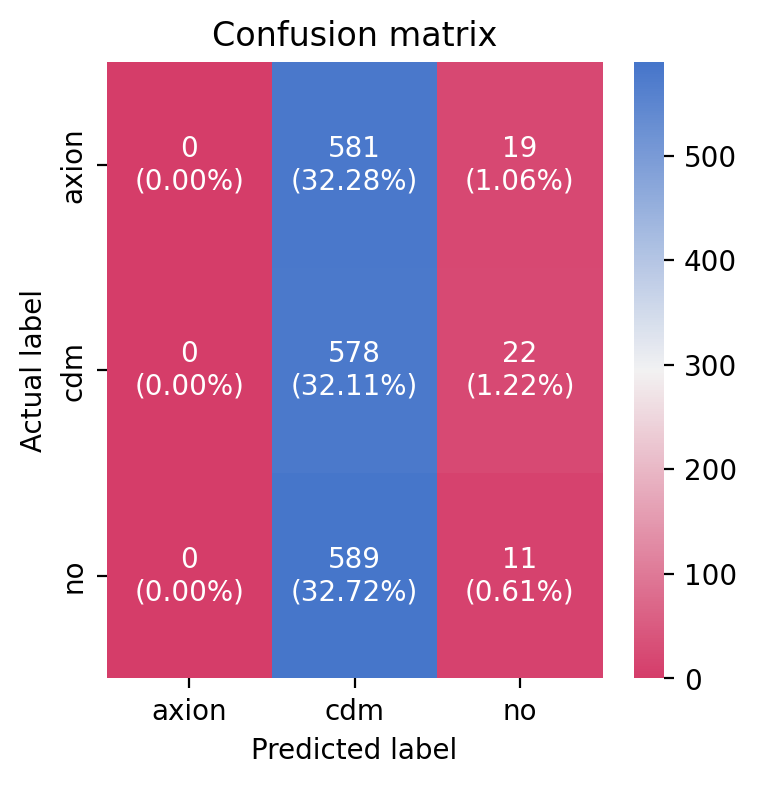

(1800, 3)


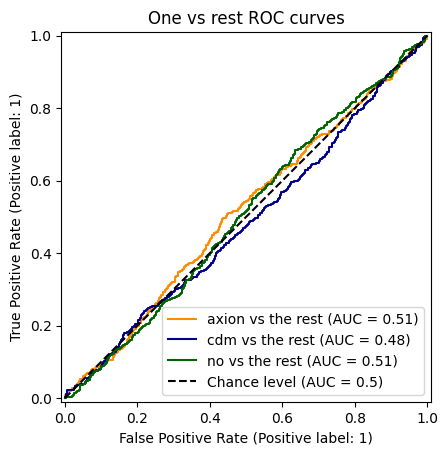

In [11]:
print(f"accuracy on test set = {test(net,test_dataloader_test2)}")
plot_cm_roc(net,test_dataloader_test2, output_path=None, n_classes=3)